In [123]:
import numpy as np
from scipy.integrate import odeint

In [124]:
  ls = 0.421
  lt = 0.419
  rs = 0.182         
  rt = 0.181
  ms = 4.8
  mt = 5.6
  Is = 0.04
  g = 9.81

params = ls,lt,rs, rt,ms,mt,Is,g

In [125]:

def hip_traj(t, B, alpha): 
  
  phi = B *np.cos(alpha* t**2)
  dphi =  -2*alpha*B *t *np.sin(alpha *t**2)
  ddphi = -2 * alpha * B * (np.sin(alpha * t**2 ) + 2 * alpha * t**2 * np.cos(alpha* t**2))

  return phi,dphi,ddphi

def trajectory(phi,dphi,ddphi): 
  theta = 8.72 + (0.33 * phi) + (0.028 * phi**2) - (0.015 * phi**3) + \
      (0.002 * phi**4) - (4.8 * np.e**-5 * phi**5) - \
      (5.6 * np.e**-6 * phi**6) + (3.3 * np.e**-7 * phi**7) - (4.8 * np.e**-9 * phi**8) 

  dtheta = -0.00473894*phi**7 + 0.0210645 *phi**6 - 0.0210645 *phi**5 - 0.10453*phi**4 + 0.008*phi**3 - 0.0045*phi**2 + 0.056*phi + 0.33
  ddtheta = -0.033*phi**6 + 0.126 *phi**5 - 0.1053*phi**4 - 0.0844684*phi**3 + 0.024*phi**2 - 0.009*phi + 0.056

  return theta, dtheta, ddtheta 

In [126]:

def regressor(q, dq, ddq,phi,dphi,ddphi):
  Y = [ddq -ddphi,ddq -ddphi,-ddphi*np.cos(q) +np.sin(q)* dphi**2 , 9.81 *np.sin(q-phi) ]
  return Y 


In [127]:
from numpy.linalg import norm

def control(x,phi,dphi,ddphi,control_params):

    q, dq= x 

    q_d, dq_d,ddq_d = trajectory(phi,dphi,ddphi)


    Lambda =50
    K =  2

    control_params = ls,lt,rs, rt,ms,mt,Is,g

    e, de = q_d - q, dq_d - dq
    q_star = de + np.dot(Lambda,e)
    dq_s = dq_d + np.dot(Lambda,e)
    ddq_s = ddq_d + np.dot(Lambda,de)
  
    Y = regressor (q,dq_s,ddq_s,phi,dphi,ddphi)
    Y_dot_q = np.dot(Y,q_star)
    eps = 10
    rho = 10
    
    if norm(Y_dot_q)>eps:
      delta_p = rho*Y_dot_q/norm(Y_dot_q)
    else:
      delta_p = rho*Y_dot_q/eps
    
    p = [Is,ms*rs**2,ms*lt*rs,ms*rs]

    u = np.dot(Y, p+delta_p) + np.dot(K, q_star)
    return u    


In [128]:
from numpy.linalg import inv
def sysode(x,t,control,control_params): 

  theta, dtheta = x 

  B = 1
  alpha = 0.1
  #get hip angle
  phi, dphi, ddphi = hip_traj(t,B,alpha) 
   
  # #get knee angle
  theta_d, dtheta_d,ddtheta_d = trajectory(phi,dphi,ddphi)

  u = control(x, phi,dphi,ddphi,control_params)
  D = Is + ms*rs**2  + (-1*(Is + ms*rs**2+ ms*lt*rs* np.cos(theta)))

  # h = ddphi*(-1*(Is + ms*rs**2+ ms*lt*rs* np.cos(theta)))+ ms*lt*rs*np.sin(theta)*dphi**2 +g*ms*rs*np.sin(theta-phi)
  h =  ms*lt*rs*np.sin(theta)*dphi**2 +g*ms*rs*np.sin(theta-phi)
  ddtheta = (u - h)/D

  dx = dtheta, ddtheta

  return dx


In [133]:
# Integration
t0 = 0 # Initial time 
tf = 20 # Final time
N = 2E3 # Numbers of points in time span
t = np.linspace(t0, tf, int(N)) # Create time span 


#trajectory parameters 
B = 1
alpha = 0.1
traj_params = B,alpha

# controller_gains = 10,1000
 
phi0,dphi0,ddphi0 = hip_traj(t0, B ,alpha)
initial_theta = trajectory(phi0,dphi0,ddphi0)


x0 = initial_theta[0],initial_theta[1]


sol = odeint(sysode, x0, t, args=(control,params)) # Integrate system
q, dq = sol[:,0], sol[:,1]
print(q)

[9.02119369 9.02364887 9.02507292 ... 8.5602737  8.55116017 8.54247681]


[9.02119369 9.02364887 9.02507292 ... 8.5602737  8.55116017 8.54247681]
[9.021193685641773, 9.021193685635742, 9.021193685545319, 9.021193685153465, 9.021193684098481, 9.021193681873969, 9.021193677828853, 9.021193671167373, 9.02119366094908, 9.021193646088832, 9.02119362535681, 9.021193597378476, 9.021193560634606, 9.02119351346126, 9.021193454049765, 9.021193380446709, 9.021193290553933, 9.02119318212847, 9.02119305278256, 9.02119289998358, 9.02119272105402, 9.021192513171417, 9.02119227336832, 9.021191998532203, 9.021191685405377, 9.021191330584935, 9.021190930522605, 9.021190481524672, 9.021189979751814, 9.02118942121899, 9.021188801795228, 9.021188117203492, 9.021187363020445, 9.021186534676223, 9.02118562745422, 9.021184636490768, 9.021183556774883, 9.021182383147913, 9.021181110303191, 9.021179732785658, 9.021178244991425, 9.021176641167347, 9.021174915410514, 9.02117306166774, 9.021171073734978, 9.021168945256752, 9.021166669725458, 9.021164240480704, 9.021161650708544, 9.02115

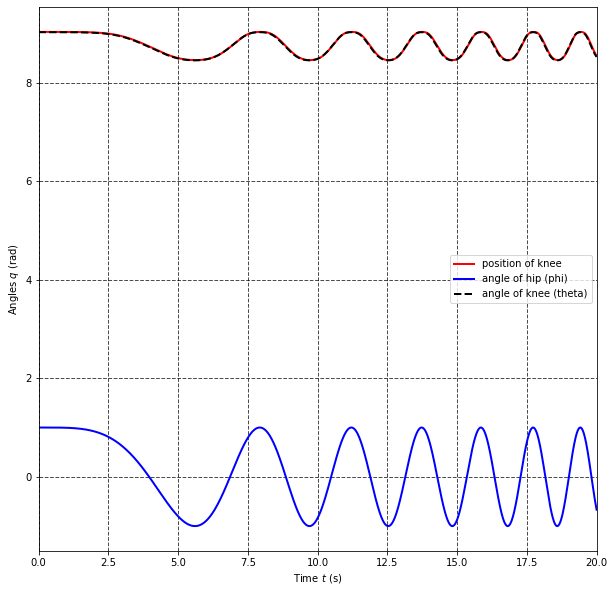

In [134]:

phi_array = []
theta_array=[]

for ti in t: 
  phi_i, dphi_i, ddphi_i =  hip_traj(ti, B, alpha)
  phi_array.append(phi_i)
  theta_i, dtheta_i,ddtheta_i = trajectory(phi_i, dphi_i, ddphi_i)
  theta_array.append(theta_i)

print(q)
print(theta_array)


from matplotlib.pyplot import *
figure(figsize=(10,10))
plot(t, q,'r', linewidth=2.0, label = 'position of knee')
plot(t, phi_array,'b', linewidth=2.0, label = 'angle of hip (phi)')
plot(t, theta_array,'k', linestyle='--' , linewidth=2.0, label = 'angle of knee (theta)')
# hlines(trajectory_params['q_d'][0], t0, tf,color = 'black', linestyle = '--', alpha = 0.7)
# hlines(trajectory_params['q_d'][1], t0, tf,color = 'black', linestyle = '--', alpha = 0.7)
# plot(t, alpha_1_exct,'r--', linewidth=2.0, alpha = 0.6)
# plot(t, alpha_2_exct,'b--', linewidth=2.0, alpha = 0.6)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, tf])
legend()
ylabel(r'Angles $q$ (rad)')
xlabel(r'Time $t$ (s)')
show()

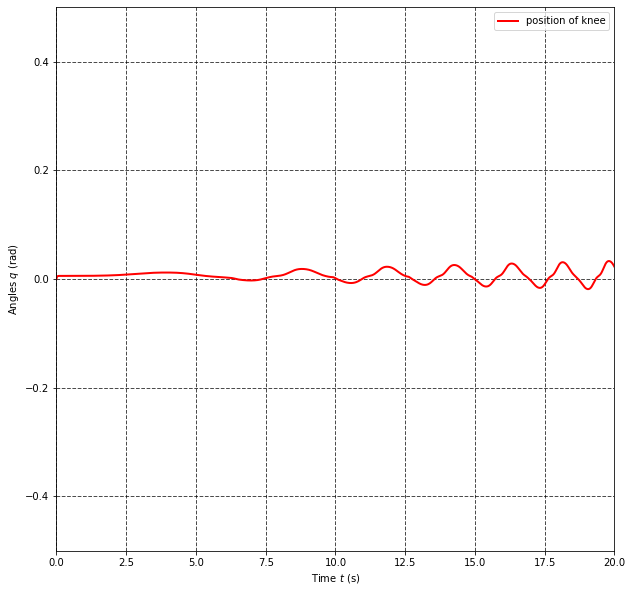

In [138]:
from matplotlib.pyplot import *
figure(figsize=(10,10))
plot(t, q-theta_array,'r', linewidth=2.0, label = 'position of knee')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
ylim([-0.5,0.5])
xlim([0, tf])
legend()
ylabel(r'Angles $q$ (rad)')
xlabel(r'Time $t$ (s)')
show()